In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from src.encoders_decoders import *
from src.losses import *

# Part I: loss and MSE visualization

In [3]:
N = 20
mu0 = torch.arange(0,10,10/N)[None,:]
sigma0 = torch.ones(N)[None,:]
q0 = 1/N*torch.ones(N)[None,:]

#Define data distribution
x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item() 

encoder = CategoricalEncoder(mu0,sigma0,q0)
decoder = GaussianDecoder(mu0,sigma0,q0)

#Define optimizer and parameters to iterate on
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.SGD(params,lr=0.001,momentum=0.9)
loss = distortion(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)

TypeError: __init__() takes 2 positional arguments but 4 were given

In [41]:
loss_class = []
mse_val = []

for i in range(1,4000):
    running_loss_tot=0
    running_mse=0
   
    loss = distortion(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)
    mse=MSE(x_data, encoder, decoder)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    running_loss_tot = loss.item()
    running_mse = mse.item()

    
    loss_class.append(running_loss_tot)
    mse_val.append(running_mse)
   


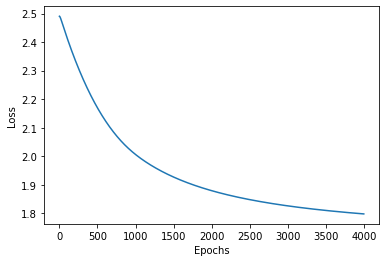

In [42]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_class) 

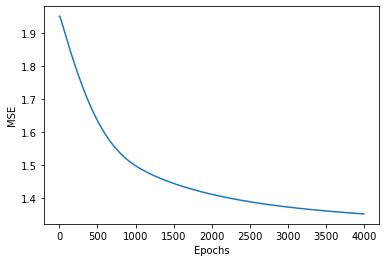

In [43]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(mse_val)

# Encoding

<ipython-input-44-9548d405fd28>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,6]))


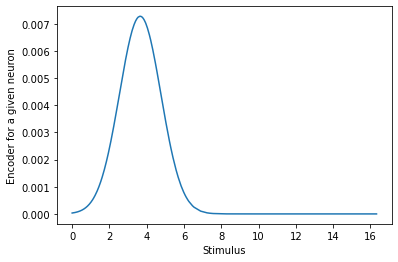

In [44]:
with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoder for a given neuron")
    plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,6]))   

<ipython-input-45-d6e3f776e5d9>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,:]))


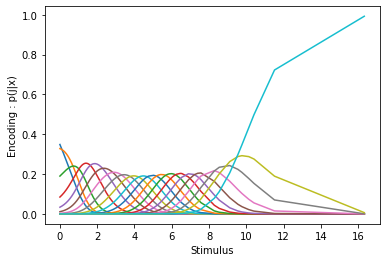

In [45]:
with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding : p(j|x)")
    plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,:]))   
    

# Decoding

In [46]:
res = GaussianDecoder(mu0,sigma0,q0)
mu_dec, sigma_dec = res(x_sorted)

C:\Users\auror\Thesis\encoders_decoders.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.q  = torch.nn.Parameter(F.softmax(q0))


In [47]:
list(mu_dec)


[tensor([0.4747], grad_fn=<UnbindBackward>),
 tensor([0.5479], grad_fn=<UnbindBackward>),
 tensor([0.7761], grad_fn=<UnbindBackward>),
 tensor([1.2202], grad_fn=<UnbindBackward>),
 tensor([1.6508], grad_fn=<UnbindBackward>),
 tensor([2.0675], grad_fn=<UnbindBackward>),
 tensor([2.5040], grad_fn=<UnbindBackward>),
 tensor([2.9726], grad_fn=<UnbindBackward>),
 tensor([3.4867], grad_fn=<UnbindBackward>),
 tensor([4.0580], grad_fn=<UnbindBackward>),
 tensor([4.6581], grad_fn=<UnbindBackward>),
 tensor([5.2446], grad_fn=<UnbindBackward>),
 tensor([5.7961], grad_fn=<UnbindBackward>),
 tensor([6.3246], grad_fn=<UnbindBackward>),
 tensor([6.8579], grad_fn=<UnbindBackward>),
 tensor([7.4060], grad_fn=<UnbindBackward>),
 tensor([7.9642], grad_fn=<UnbindBackward>),
 tensor([8.5223], grad_fn=<UnbindBackward>),
 tensor([9.0576], grad_fn=<UnbindBackward>),
 tensor([9.7708], grad_fn=<UnbindBackward>)]

In [48]:
list(sigma_dec)

[tensor([0.3694], grad_fn=<UnbindBackward>),
 tensor([0.4048], grad_fn=<UnbindBackward>),
 tensor([0.5316], grad_fn=<UnbindBackward>),
 tensor([0.7322], grad_fn=<UnbindBackward>),
 tensor([0.8613], grad_fn=<UnbindBackward>),
 tensor([0.9288], grad_fn=<UnbindBackward>),
 tensor([0.9575], grad_fn=<UnbindBackward>),
 tensor([0.9696], grad_fn=<UnbindBackward>),
 tensor([0.9959], grad_fn=<UnbindBackward>),
 tensor([1.0547], grad_fn=<UnbindBackward>),
 tensor([1.1030], grad_fn=<UnbindBackward>),
 tensor([1.0957], grad_fn=<UnbindBackward>),
 tensor([1.0530], grad_fn=<UnbindBackward>),
 tensor([1.0331], grad_fn=<UnbindBackward>),
 tensor([1.0546], grad_fn=<UnbindBackward>),
 tensor([1.0870], grad_fn=<UnbindBackward>),
 tensor([1.1058], grad_fn=<UnbindBackward>),
 tensor([1.1045], grad_fn=<UnbindBackward>),
 tensor([1.1015], grad_fn=<UnbindBackward>),
 tensor([1.8993], grad_fn=<UnbindBackward>)]

In [49]:
gaussian = torch.distributions.normal.Normal(mu_dec, sigma_dec)

In [50]:
a = (gaussian.log_prob(x_sorted.transpose(0,1))).transpose(0,1)

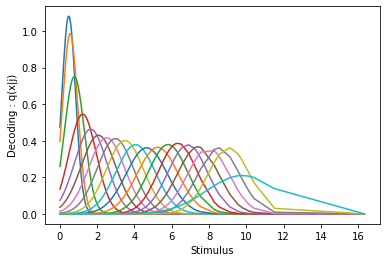

In [51]:
with torch.no_grad():
    plt.plot(x_sorted, torch.exp(a[:,:]))
    plt.xlabel("Stimulus")
    plt.ylabel("Decoding : q(x|j)")
    
    
    

# Reconstruction error

In [12]:
#to visualize the error, use the first return in the GaussianDecoder

q_sample = torch.squeeze(torch.distributions.categorical.Categorical((F.softmax(decoder.q))).sample((500,)))
q_sample.shape

<ipython-input-12-f0c6d586cba2>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q_sample = torch.squeeze(torch.distributions.categorical.Categorical((F.softmax(decoder.q))).sample((500,)))


torch.Size([500])

In [13]:
muext,sigmaext =decoder(F.one_hot(q_sample).to(dtype=torch.float32))

In [14]:
x_sample = torch.distributions.normal.Normal(muext,sigmaext).sample(())
x_sample.shape


torch.Size([20, 1])

ValueError: x must have 2 or fewer dimensions

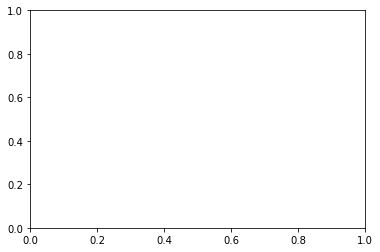

In [15]:
with torch.no_grad():
    
    plt.hist(x_sample[:,None,:].numpy())

In [16]:
x_sample_sort,indices = x_sample.sort(dim=0)
x_sample_sort.shape
#x_sorted.shape

torch.Size([20, 1])

In [17]:
error = abs(x_sample_sort - x_sorted)   #| reconstructed_x via generative model -  x_data|
plt.plot(error)

RuntimeError: The size of tensor a (20) must match the size of tensor b (500) at non-singleton dimension 0

# MSE

Computing the loss as Mean Squared Erros + KL Divergence

In [52]:
optimizer = torch.optim.SGD(params,lr=0.001,momentum=0.9)
loss = MSE(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)

C:\Users\auror\Thesis\losses.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mse = ((F.softmax(p_j_x))*(x_data**2 + decoder.mu.transpose(0,1)**2 -2*x_data*decoder.mu.transpose(0,1) + decoder.sigma.transpose(0,1)**2)).sum(dim=1).mean()
C:\Users\auror\Thesis\losses.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = ((F.softmax(p_j_x))*(F.log_softmax(p_j_x) - F.log_softmax(decoder.q))).sum(dim=1).mean()
C:\Users\auror\Thesis\losses.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = ((F.softmax(p_j_x))*(F.log_softmax(p_j_x) - F.log_softmax(decoder.q))).sum(dim=1).mean()


In [53]:
loss_mse = []
mse_val1 = []

for i in range(1,4000):
    running_loss_tot=0
    running_mse_val1=0
    
    
    loss = MSE(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)
    mse1=MSE(x_data, encoder, decoder)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    running_loss_tot = loss.item()
    running_mse_val1=mse1.item()
    loss_mse.append(running_loss_tot)
    mse_val1.append(running_mse_val1)

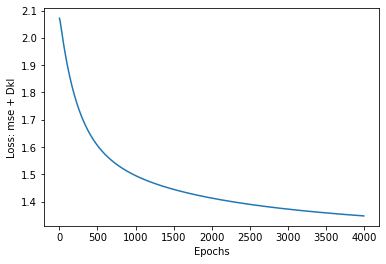

In [54]:
plt.xlabel("Epochs")
plt.ylabel("Loss: mse + Dkl")
plt.plot(loss_mse) 


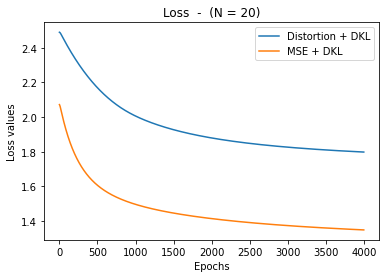

In [55]:
plt.plot(loss_class, label = "Distortion + DKL")
plt.plot(loss_mse, label = "MSE + DKL")
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Loss  -  (N = 20)')
plt.legend()

plt.show()

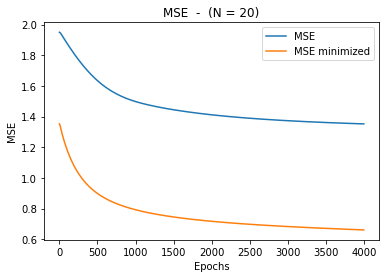

In [56]:
plt.plot(mse_val, label = "MSE")
plt.plot(mse_val1, label = "MSE minimized")
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE  -  (N = 20)')
plt.legend()

plt.show()

# Loss behaviour for different N values

In [32]:

x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)

#TRAINING FUNCTION (to move in a script)

def training(N):
    #parameters initialization
    mu0 = torch.arange(0,10,10/N)[None,:]
    sigma0 = torch.ones(N)[None,:]
    q0 = 1/N*torch.ones(N)[None,:]
    
    #model and parameters
    encoder = CategoricalEncoder(mu0,sigma0,q0)
    decoder = GaussianDecoder(mu0,sigma0,q0)
    params = list(decoder.parameters()) + list(encoder.parameters())
    optimizer = torch.optim.SGD(params,lr=0.001,momentum=0.9)
    loss = distortion(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)
    
    #training
    loss_val = []
    mse_val = []
    for i in range(1,8000):
        running_loss=0
        running_mse=0
   
        loss = distortion(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)
        mse=MSE(x_data, encoder, decoder)

        optimizer.zero_grad()
        loss.backward()
    
        optimizer.step()
    
        running_loss = loss.item()
        running_mse = mse.item()

    
        loss_val.append(running_loss)
        mse_val.append(running_mse)
        
    
    return loss_val, mse_val
       
   

In [33]:
loss_10 , mse_10 = training(10)
loss_15 , mse_15 = training(15)
loss_20 , mse_20 = training(20)
loss_25 , mse_25 = training(25)
loss_30 , mse_30 = training(30)
loss_35 , mse_35 = training(35)
loss_40 , mse_40 = training(40)
loss_45 , mse_45 = training(45)
loss_50 , mse_50 = training(50)
loss_55 , mse_55 = training(55)
loss_60 , mse_60 = training(60)


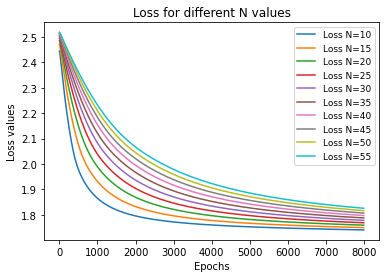

In [36]:
plt.plot(loss_10, label = "Loss N=10")
plt.plot(loss_15, label = "Loss N=15")
plt.plot(loss_20, label = "Loss N=20")
plt.plot(loss_25, label = "Loss N=25")
plt.plot(loss_30, label = "Loss N=30")
plt.plot(loss_35, label = "Loss N=35")
plt.plot(loss_40, label = "Loss N=40")
plt.plot(loss_45, label = "Loss N=45")
plt.plot(loss_50, label = "Loss N=50")
plt.plot(loss_55, label = "Loss N=55")

plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title( 'Loss for different N values')
plt.legend(loc = "upper right", prop={'size': 9})

plt.show()

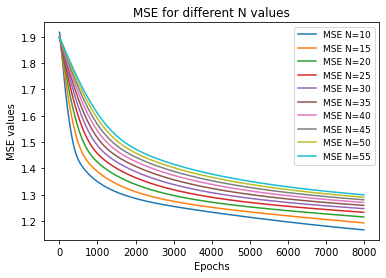

In [38]:
plt.plot(mse_10, label = "MSE N=10")
plt.plot(mse_15, label = "MSE N=15")
plt.plot(mse_20, label = "MSE N=20")
plt.plot(mse_25, label = "MSE N=25")
plt.plot(mse_30, label = "MSE N=30")
plt.plot(mse_35, label = "MSE N=35")
plt.plot(mse_40, label = "MSE N=40")
plt.plot(mse_45, label = "MSE N=45")
plt.plot(mse_50, label = "MSE N=50")
plt.plot(mse_55, label = "MSE N=55")

plt.xlabel('Epochs')
plt.ylabel('MSE values')
plt.title('MSE for different N values')
plt.legend(loc = "upper right", prop={'size': 9})

plt.show()